In [1]:
!pip install mplcyberpunk

In [3]:
import nltk
import matplotlib.pyplot as plt
import mplcyberpunk

nltk.download('punkt')
plt.style.use(["dark_background", "cyberpunk"])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import os

def read_text(paths):
    documents = []
    for root, dirs, files in os.walk(paths):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    lines = f.readlines()
                    content = ''.join(lines)
                    documents.append(content)
            except UnicodeDecodeError:
                print(f"Error reading file: {file_path}")          
    return '\n'.join(documents)

spam = ['\ufeff', '\t', '\u2060', '¦', '«', '»', '\n', "\'"]

def clear_vocab(text: str) -> set:
    extra_symbols = ['<EOS>', '<BOS>', '<UNK>']
    vocab = set()
    for char in text:
        if char not in vocab:
            vocab.add(char)
    for char in extra_symbols:
        vocab.add(char)     
    return vocab

def clear_text(symbols: list, text: str) -> None:
    new_sentences = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        new_sentence = []
        for symbol in sentence:
            if symbol not in symbols:
                new_sentence.append(symbol)
        if len(new_sentence) >= 20:
            new_sentences.append(''.join(new_sentence))
    return new_sentences    

In [47]:
paths = '/kaggle/input/bbc-news-summary/'
text = read_text(paths)

In [7]:
from sklearn.model_selection import train_test_split

sentences = clear_text(spam, text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

In [8]:
vocab_set = clear_vocab(''.join(sentences))
char_to_ind = {char: ind for ind, char in enumerate(vocab_set)}
ind_to_char = {ind: char for char, ind in char_to_ind.items()}

In [9]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, sentences: list):
        self.data = sentences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index]

def collate(input_batch: list, char_to_ind: dict, mode='char'):
    if mode == 'char':
        seq_lens = [len(list(sent)) for sent in input_batch]
    elif mode == 'word':
        seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)
    new_batch = []
    masks = []
    for sequence in input_batch:
        new_sequence = [char_to_ind['<BOS>'], ]
        mask = [1, ]
        first = True
        for i in range(max_seq_len):
            if i < len(sequence):
                if sequence[i] in char_to_ind:
                    new_sequence.append(char_to_ind[sequence[i]])
                    mask.append(1)
                else:
                    new_sequence.append(char_to_ind['<UNK>'])
                    mask.append(0)
            else:
                if first:
                    mask.append(1)
                    first = False
                else:
                    mask.append(0)
                new_sequence.append(char_to_ind['<EOS>'])
        new_sequence.append(char_to_ind['<EOS>'])
        if len(sequence) == max_seq_len:
            mask.append(1)
        else:
            mask.append(0)
        new_batch.append(new_sequence)
        masks.append(mask)
    sequences = torch.LongTensor(new_batch)
    masks = torch.Tensor(masks)
    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:],
        'masks': masks[:, 1:]
    }
    return new_batch

In [10]:
from torch.utils.data import DataLoader
from functools import partial

train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=char_to_ind))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=char_to_ind))

In [11]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab, num_lstm_layers=1, hidden_dim=128):
        super().__init__()
        self.embed_dim = 300
        self.hidden_dim = hidden_dim
        self.vocab_size = len(vocab)
        self.embed_layer = nn.Embedding(self.vocab_size, self.embed_dim)
        self.recurrent_layer = nn.LSTM(self.embed_dim, self.hidden_dim, batch_first=True, num_layers=num_lstm_layers)
        self.linear_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        self.tanh = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embed_layer(input_batch)
        x, _ = self.recurrent_layer(x)
        x = self.linear_layer(self.tanh(x))
        x = self.projection(x).permute(0, 2, 1)
        return x

In [12]:
from IPython.display import clear_output

def train_model(model, criterion, optimizer, dataloader, epochs=2):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_history = []
    for i in range(epochs):
        for j, batch in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            total_loss.backward()
            optimizer.step()
            train_history.append((i * len(dataloader) * len(batch) + j * len(batch), total_loss.item()))
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            plt.legend(); plt.grid(); plt.show()

In [13]:
from tqdm import tqdm

def validate_model(model, criterion, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            perplexity.append(torch.exp(total_loss).item())
    perplexity = sum(perplexity) / len(perplexity)
    return perplexity

In [14]:
model = LSTMModel(char_to_ind)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

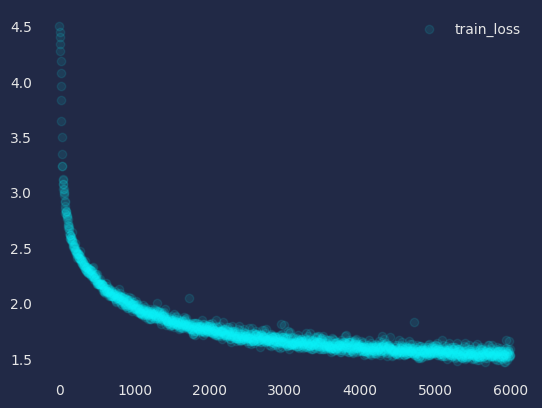

100%|██████████| 1001/1001 [06:12<00:00,  2.69it/s]


In [15]:
train_model(model, criterion, optimizer, train_loader)

In [16]:
validate_model(model, criterion, val_loader)

100%|██████████| 429/429 [00:37<00:00, 11.35it/s]


4.69530398695619

In [17]:
import numpy as np

def inference(text, char_to_ind, ind_to_char, max_len=150, temperature=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        while True:
            batch = collate([text], char_to_ind)
            last_logits = model(batch['input_ids'].to(device))[0, :, -1]
            probs = torch.softmax(last_logits, 0).cpu()
            if temperature == 0.0:
                next_token = ind_to_char[torch.argmax(probs, 0).item()]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(char_to_ind.keys()), p=probs)
            if next_token == '<EOS>' or len(text) == 100:
                break
            text += next_token
    return text

In [18]:
text = 'A Christmas '
inference(text, char_to_ind, ind_to_char, temperature=0.4)

'A Christmas in the Apple will be a could search in the plans a going to recent to be the world for t'

Теперь увеличим количество слоев до 5

In [19]:
model = LSTMModel(char_to_ind, num_lstm_layers=5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

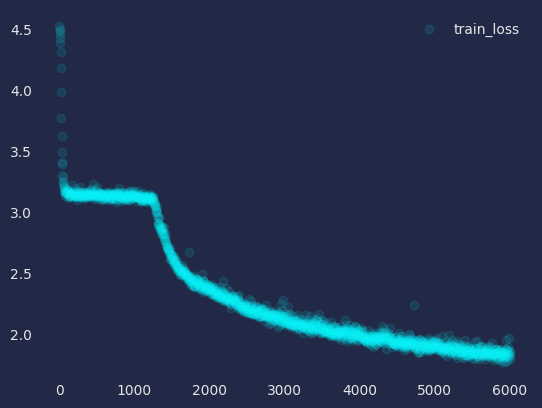

100%|██████████| 1001/1001 [07:05<00:00,  2.35it/s]


In [20]:
train_model(model, criterion, optimizer, train_loader)

In [21]:
validate_model(model, criterion, val_loader)

100%|██████████| 429/429 [00:59<00:00,  7.26it/s]


6.250707007232524

In [22]:
inference(text, char_to_ind, ind_to_char, temperature=0.4)

'A Christmas the said and the particicial at the intert ut the tink the prevent said the said and an '

### Теперь изменим токенизацию на word tokenize

In [23]:
from collections import Counter

def clear(text: str) -> None:
    counter = Counter()
    vocab = {'<EOS>', '<BOS>', '<UNK>'}
    sentence_tokenizer = nltk.tokenize.PunktSentenceTokenizer()
    punct_tokenizer = nltk.tokenize.TweetTokenizer()
    new_sentences = []
    for sentence in sentence_tokenizer.tokenize(text):
        if '"' not in sentence:
            words = punct_tokenizer.tokenize(sentence.replace('\\', ''))
            for word in words:
                counter[word] += 1
            if len(words) > 4:
                new_sentences.append(words)
    for w, c in counter.items():
        if c > 100:
            vocab.add(w)  
    return new_sentences, vocab

In [24]:
origin_text = read_text(paths)

sentences, vocab = clear(origin_text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

word2ind = {char: ind for ind, char in enumerate(vocab)}
ind2word = {ind: char for char, ind in word2ind.items()}

In [25]:
train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=128, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

In [26]:
model = LSTMModel(word2ind)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

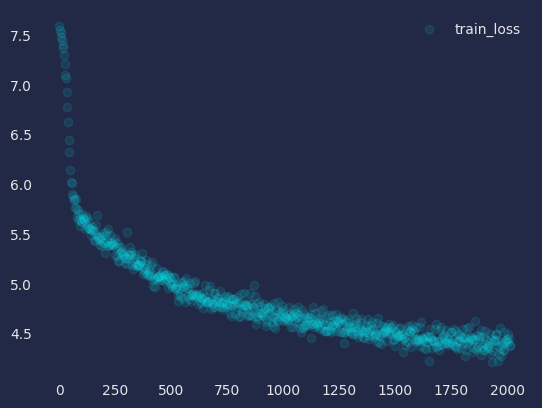

100%|██████████| 336/336 [06:38<00:00,  1.19s/it]


In [27]:
train_model(model, criterion, optimizer, train_loader)

In [28]:
validate_model(model, criterion, val_loader)

100%|██████████| 144/144 [01:15<00:00,  1.90it/s]


82.52276277542114

In [29]:
def inference_word(model, text, word2ind, ind2word, max_len=150, temperature=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    punct_tokenizer = nltk.tokenize.TweetTokenizer()
    words = punct_tokenizer.tokenize(text)
    with torch.no_grad():
        while True:
            batch = collate([words], word2ind, mode='word')
            last_logits = model(batch['input_ids'].to(device))[0, :, -1]
            probs = torch.softmax(last_logits, 0).cpu()
            if temperature == 0.0:
                next_token = ind2word[torch.argmax(probs, 0).item()]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(word2ind.keys()), p=probs)
            if next_token == '<EOS>' or len(words) == 30:
                break
            words.append(next_token)
    return ' '.join(words)

In [30]:
text = 'A Christmas tree '
inference_word(model, text, word2ind, ind2word, temperature=0.4)

'A Christmas tree in the last year , which was a bit of the final in the top of the US and is expected to be a new record of'

In [31]:
model = LSTMModel(word2ind, num_lstm_layers=5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

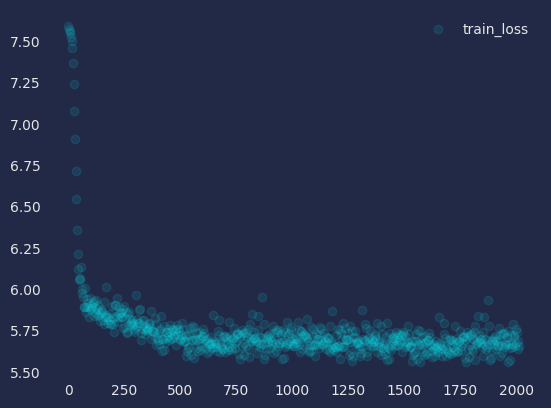

100%|██████████| 336/336 [06:53<00:00,  1.23s/it]


In [32]:
train_model(model, criterion, optimizer, train_loader)

In [33]:
validate_model(model, criterion, val_loader)

100%|██████████| 144/144 [01:19<00:00,  1.82it/s]


292.31075837877063

In [34]:
text = 'A Christmas tree '
inference_word(model, text, word2ind, ind2word, temperature=0.6)

'A Christmas tree , the of the the in in the that the . that the . a'

### Теперь перейдем к тонизатору BPE

In [52]:
!pip install chardet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 4.2 MB/s eta 0:00:0000:01


In [53]:
import os
import chardet

def copy_files_with_encoding_fix(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(dst_dir, file)
            try:
                with open(src_file, 'rb') as f:
                    content = f.read()
                    result = chardet.detect(content)
                    encoding = result['encoding']
                    if encoding is None or encoding == 'ascii':
                        encoding = 'utf-8'
                    text = content.decode(encoding, errors='replace')
                with open(dst_file, 'w', encoding='utf-8') as f:
                    f.write(text)
            except (UnicodeDecodeError, IOError):
                print(f"Error copying file: {src_file}")
                continue
    print(f"Files copied to: {dst_dir}")

src_directory = '/kaggle/input/bbc-news-summary/'
dst_directory = '/kaggle/working/'
copy_files_with_encoding_fix(src_directory, dst_directory)

Files copied to: /kaggle/working/


In [56]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer(add_prefix_space=True)
special_tokens = ['<UNK>', '<EOS>', '<BOS>']
filepaths = []

for root, dirs, files in os.walk(dst_directory):
        for file in files:
            file_path = os.path.join(root, file)
            filepaths.append(file_path)

tokenizer.train(filepaths, special_tokens=special_tokens, min_frequency=2, show_progress=True, vocab_size=1000)
tokenizer.save("/kaggle/working/bpe_char_tokenizer.json")

In [ ]:
from tokenizers import Tokenizer

bpe_tokenizer = Tokenizer.from_file("/kaggle/working/bpe_char_tokenizer.json")

In [57]:
def clear(text: str) -> None:  
    sentence_tokenizer = nltk.tokenize.PunktSentenceTokenizer()
    bpe_tokenizer = Tokenizer.from_file("/kaggle/working/bpe_char_tokenizer.json")
    new_sentences = []
    for sentence in sentence_tokenizer.tokenize(text):
        if '"' not in sentence:
            sentence = sentence.replace('\\', '')
            tokens = bpe_tokenizer.encode(sentence).ids
            new_sentences.append(tokens)    
    return new_sentences

In [59]:
origin_text = read_text(dst_directory)

sentences = clear(origin_text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

In [61]:
def collate(input_batch: list, vocab=None):
    seq_lens = [len(seq) for seq in input_batch]
    max_seq_len = max(seq_lens)
    new_batch = []
    masks = []
    for sequence in input_batch:
        new_seq = vocab.encode('<BOS>').ids + sequence + vocab.encode('<EOS>').ids * (max_seq_len - len(sequence) + 1)
        cur_mask = [1] * (len(sequence) + 2) + [0] * (max_seq_len - len(sequence))
        new_batch.append(new_seq)
        masks.append(cur_mask)
    sequences = torch.LongTensor(new_batch)
    masks = torch.Tensor(masks)
    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:],
        'masks': masks[:, 1:]
    }
    return new_batch

In [63]:
bpe_tokenizer = Tokenizer.from_file("/kaggle/working/bpe_char_tokenizer.json")

In [64]:
train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=partial(collate, vocab=bpe_tokenizer))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=partial(collate, vocab=bpe_tokenizer))

In [65]:
model = LSTMModel(bpe_tokenizer.get_vocab(), num_lstm_layers=1, hidden_dim=512)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

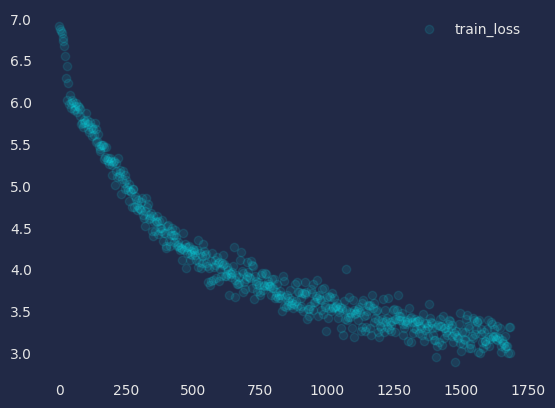

100%|██████████| 281/281 [01:15<00:00,  3.73it/s]


In [66]:
train_model(model, criterion, optimizer, train_loader)

In [67]:
validate_model(model, criterion, val_loader)

100%|██████████| 121/121 [00:01<00:00, 114.78it/s]


29.405984043089813

In [68]:
def inference_bpe(model, text, bpe_tokenizer, max_len=30, temperature=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    words = bpe_tokenizer.encode(text).ids
    with torch.no_grad():
        while True:
            batch = collate([words], bpe_tokenizer)
            logits = model(batch['input_ids'].to(device))
            probs = torch.softmax(logits[0, :, -1], 0).cpu()
            if temperature == 0.0:
                next_token = torch.argmax(probs, 0).item()
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(bpe_tokenizer.get_vocab().values()), p=probs) 
            if next_token == 1 or len(words) == 30:
                break
            words.append(next_token)
        gen_text = bpe_tokenizer.decode(words)
    return gen_text

In [71]:
text = 'Bisness '

In [75]:
inference_bpe(model, text , bpe_tokenizer, temperature=0)

" Bisness knocking thendy-based manager, the firm's main shareholder,"

In [81]:
model = LSTMModel(bpe_tokenizer.get_vocab(), num_lstm_layers=5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

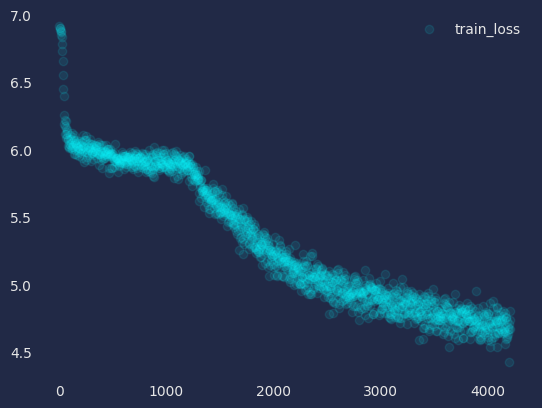

100%|██████████| 281/281 [01:19<00:00,  3.54it/s]


In [82]:
train_model(model, criterion, optimizer, train_loader, epochs=5)

In [83]:
validate_model(model, criterion, val_loader)

100%|██████████| 121/121 [00:00<00:00, 122.84it/s]


121.36430056233051

In [119]:
inference_bpe(model, text , bpe_tokenizer, temperature=0.)

' Bisness edta, the the the the the the the the the the the the the the the the the the the the the'

<b>Сделаем некоторые выводы.  Лучше всего себя показали токенизаторы по словам, которые дают порой хорошие связанные предложения, связанные по смыслу

Также обратим внимание на то, что однослойные LSTM справляются лучшше, чем многослойные. Возможно, стоило уменьшить количество слоев с 5 на меньшее число <b>